# Example of DOPER - Generator Assets

### This examples demonstrates the DOPER framework for load control with about 150 kW building base load and 100 kW Photovoltaic (PV) generation.

In [1]:
import os
import sys
import pandas as pd
import matplotlib.pyplot as plt
from pprint import pprint
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
%matplotlib inline

# from IPython.display import HTML
# HTML('''<script>
# code_show=true; 
# function code_toggle() {
#  if (code_show){
#  $('div.input').hide();
#  } else {
#  $('div.input').show();
#  }
#  code_show = !code_show
# } 
# $( document ).ready(code_toggle);
# </script>
# <form action="javascript:code_toggle()">
# <input type="submit" value="Click here to toggle on/off the raw code."></form>
# ''')

### Import DOPER modules

DOPER consists of several modules which are imported here.

New additions:
- genset submodule with load control variables constraints
- example function to add load control assets to input parameters
- example function to divide load profile into circuit-specific load profiles

In [2]:
from doper import DOPER, get_solver, get_root, standard_report
from doper.models.basemodel import base_model
from doper.models.genset import add_genset
from doper.models.loadControl import add_loadControl
from doper.examples.example import default_parameter, ts_inputs, ts_inputs_planned_outage, parameter_add_genset, parameter_add_loadcontrol, ts_inputs_load_shed
from doper.plotting import plot_dynamic

### Setup Optimization Model

DOPER passes the inputs as first arguments and parameter as second argument to the optimization model (control_model). In this example two models are loaded:
* the "base_model" with energy balance of on-site generation, e.g. Photovoltaic, and demand, e.g. building base laod
* the "add_battery" model which adds individual batteries or electric vehicles, as defined by the input parameters

An objective function is defined as the sum of energy and demand cost, eventual revenue from exporting energy, and from frequency regulation. The weighting between the objectives is again defined within the parameters of the model.

New additions:
- use add_loadControl func to add load control constraints. Similar to previous storage, genset approach
- add load shed costs to objective function formulation

In [3]:
from pyomo.environ import Objective, minimize

def control_model(inputs, parameter):
    model = base_model(inputs, parameter)
    model = add_genset(model, inputs, parameter)
    model = add_loadControl(model, inputs, parameter)
    
    def objective_function(model):
        return model.sum_energy_cost * parameter['objective']['weight_energy'] \
               + model.sum_demand_cost * parameter['objective']['weight_demand'] \
               + model.sum_export_revenue * parameter['objective']['weight_export'] \
               + model.fuel_cost_total * parameter['objective']['weight_energy'] \
               + model.load_shed_cost_total
    model.objective = Objective(rule=objective_function, sense=minimize, doc='objective function')
    return model

### Load Example Parameter

New additions:
* System: "load_control" field allows for enabling/disabling load control
* load_control: List of objects defining load control circuits

In [4]:
parameter = default_parameter()
parameter = parameter_add_genset(parameter)
parameter = parameter_add_loadcontrol(parameter)

print("parameter 'system' object:")
pprint(parameter['system'])
print('')

print("parameter 'load_control' object:")
pprint(parameter['load_control'])
print('')

parameter 'system' object:
{'battery': False,
 'external_gen': False,
 'genset': True,
 'hvac_control': False,
 'load_control': True,
 'pv': True,
 'reg_bidding': False,
 'reg_response': False}

parameter 'load_control' object:
[{'cost': 0.05, 'name': 'a', 'outageOnly': False},
 {'cost': 0.3, 'name': 'b', 'outageOnly': False}]



### Load Example Data

The input data in this example is chosen to represent a medium-sized office building with rooftop photovoltaic system.

New additions:
- When using load control, load profiles for each circuit must be provided in the 'data' input
- Circuit profiles should use the naming convention load_circuit_[name of circuit]
- Aggregated load profile 'load_demand' will not be used and can be omitted

In [5]:
data = ts_inputs_load_shed(parameter)

### Conduct Optimization

In order to conduct the optimization, the DOPER object is initialized with the model, parameter, and the pyomo_to_pandas converter function. In the next step, the model is evaluated with the "do_optimization" class function. It takes the current inputs as input and returns a list of results.

Note that DOPER is built for application as Model Predictive Control (MPC) where the optimization model is periodically, e.g. every five minutes, updated with the most recent inputs, and reevaluated. However, in this example, do_optimization is only executed once.

In [6]:
# Define the path to the solver executable
solver_path = get_solver('cbc', solver_dir=os.path.join(get_root(), 'solvers'))
print(solver_path)
# Initialize DOPER
smartDER = DOPER(model=control_model,
                 parameter=parameter,
                 solver_path=solver_path)

# Conduct optimization
res = smartDER.do_optimization(data)

# Get results
duration, objective, df, model, result, termination, parameter = res
print(standard_report(res))

C:\Users\nicholas\.conda\envs\doperDev\lib\site-packages\doper\solvers\Windows64\cbc.exe
Solver			CBC 2.10.3
Duration [s]		4.03
Objective [$]		3058.71			2995.18 (Total Cost)
Cost [$]		120.17 (Energy)	2875.01 (Demand)
CO2 Emissions [kg]		2694.17



### Result for Site



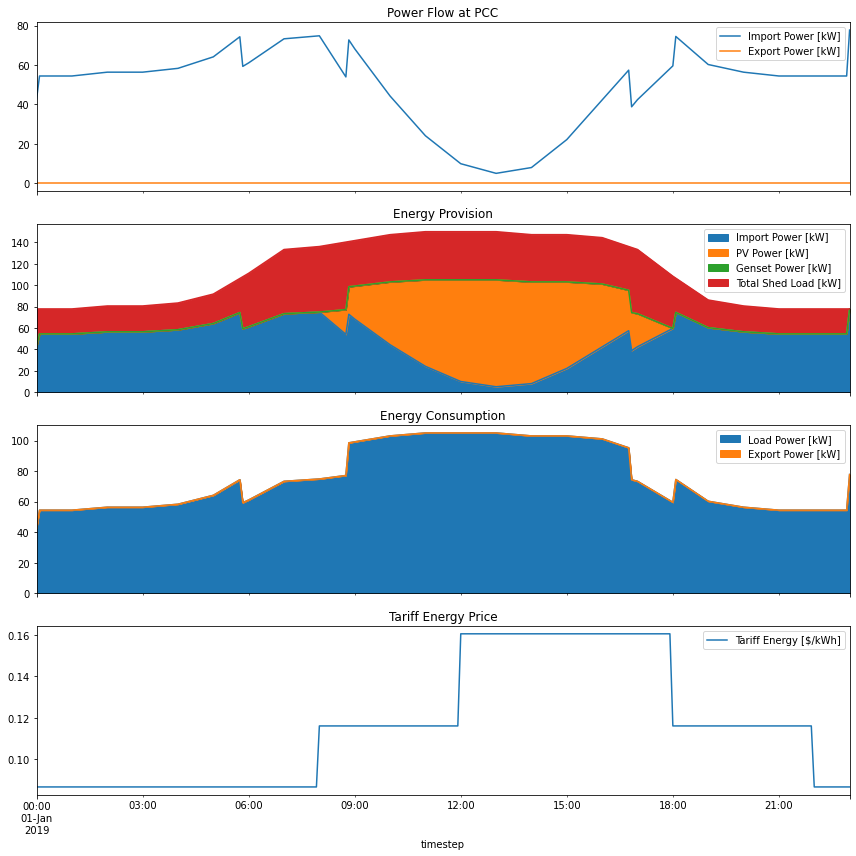

In [7]:
plotData = plot_dynamic(df, parameter, plotFile = None, plot_reg=False)

### Outage Only Functionality

In the previous example, one load circuit could be shed for economic reasons. In the next example, both circuits are set to outageOnly, meaning they can only be shed when grid availability is lost.

In [8]:
# update load control to run as outage only
parameter['load_control'][0]['outageOnly'] = True
parameter['load_control'][1]['outageOnly'] = True

# add mid-horizon outage to previous timeseries data
data = ts_inputs_load_shed(parameter)
data = ts_inputs_planned_outage(parameter, data)

# Initialize DOPER
smartDER = DOPER(model=control_model,
                 parameter=parameter,
                 solver_path=solver_path)

# Conduct optimization
res = smartDER.do_optimization(data)

# Get results
duration, objective, df, model, result, termination, parameter = res
print(standard_report(res))

Solver			CBC 2.10.3
Duration [s]		4.16
Objective [$]		3435.24			3255.57 (Total Cost)
Cost [$]		105.96 (Energy)	3149.61 (Demand)
CO2 Emissions [kg]		3042.86



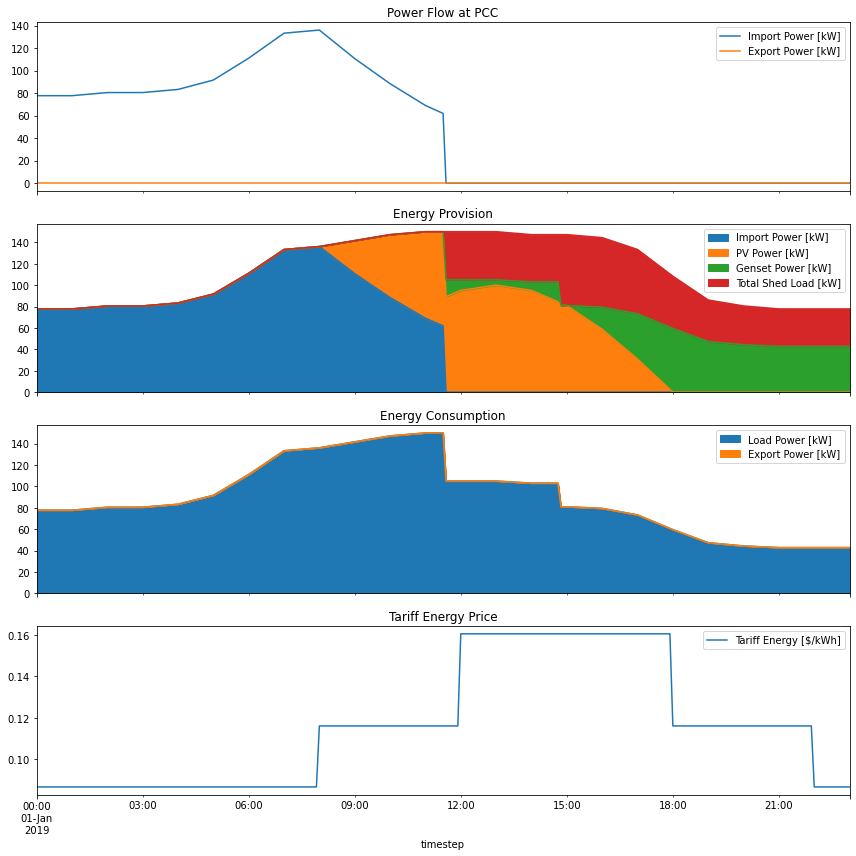

In [9]:
plotData = plot_dynamic(df, parameter, plotFile = None, plot_reg=False)

### Development to-do list

- develop constraint for transition time for shed begin to restart (e.g. minimum load shed duration)